# 12.1 深度学习建模实验中数据集生成函数的创建与使用

为了方便后续练习的的展开，我们尝试自己创建一个数据生成器，用于自主生成一些符合某些条件，具备某些特性的数据集。相比于传统的机器学习领域，深度学习的数据集往往更加复杂，大多数情况也无法把数据生成数据表来进行查看，在建模过程中，往往都是设计完模型后直接使用训练模型，只能通过一些指标来观测模型效果，外加复杂神经网络内部其实是“黑箱”，因此我们基本只能控制流程，输入数据，观测结果，说是炼丹师叶并不为过。不过在学习阶段，尤其是在学习优化算法的过程，我们还是希望能够从更多的角度观测数据，观测建模过程，这就需要我们自己动手，创建一些数据用于实验的原材料，通过一些实验深入了解模型原理，从“炼丹师”向“化学家”更进一步。

* 导入相关的包

In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset


## 12.1.1 回归类数据集创建方法

1. 手动生成数据

回归类模型的数据，特征和标签都是连续型数值

    正常情况下，应该是对于连续型数值标签的预测，我们采用回归模型，此处因为先生成数据后进行建模，因此我们称可用于回归训练的数据为回归类模型数据，分类模型数据亦然。

* 数据生成

生成两个特征，存在偏差，自变量和因变量存在线性关系的数据集

In [2]:
num_inputs = 2          # 两个特征
num_examples = 1000     # 总共1000条数据

然后尝试通过线性方程，确定自变量和因变量的真实关系

In [3]:
torch.manual_seed(420)      # 设置随机数种子

In [6]:
# 线性方程系数
w_true = torch.tensor([2, -1], dtype= torch.float32).reshape(2, 1)
b_true = torch.tensor(1., dtype= torch.float32)

# 特征和标签取值
features = torch.randn(num_examples, num_inputs)
labels_true = torch.mm(features, w_true) + b_true
labels = labels_true + torch.randn(size = labels_true.shape)*0.01

> 此处设置所有的数据都是浮点型

注意，此时labels_true和features满足严格意义上的线性方程关系

$$ y = 2x_{1} - x_{2} +1 $$

但我们实际使用的标签labels，则是在labels_true的基础上增添了一个扰动项，torch.randn(size = labels_true.shape)*0.01，这其实也符合我们一般获取数据的情况：真实世界或许存在某个规律，但我们搜集到的数据往往会因为各种原因存在一定的误差，无法完全描述真实世界的可观规律，这其实也是模型误差的来源之一（另一个误差来源就是模型本身捕获规律的能力）。这其中，$ y = 2x_{1} - x_{2} +1 $ 相当于我们从上帝视角创建的数据真实服从的规律，而扰动项，则相当于认为创建爱你的获取数据时的误差。

    这种按照某种规律生成的数据，又人为添加扰动项的创建数据的方法，也是数学领域创建数据的一般方法。

In [7]:
features[:10]

tensor([[-1.0979,  0.1825],
        [-0.2895, -0.8303],
        [ 1.4373,  1.6355],
        [ 0.2984, -0.3024],
        [-1.1839,  0.8756],
        [ 1.1910, -0.9895],
        [-1.1805,  0.3646],
        [ 1.6526,  2.8122],
        [-0.8005,  1.6628],
        [-0.2353, -1.6575]])

In [8]:
labels[:10]

tensor([[-1.3752],
        [ 1.2458],
        [ 2.2373],
        [ 1.8862],
        [-2.2508],
        [ 4.3742],
        [-1.7334],
        [ 1.4933],
        [-2.2590],
        [ 2.1970]])

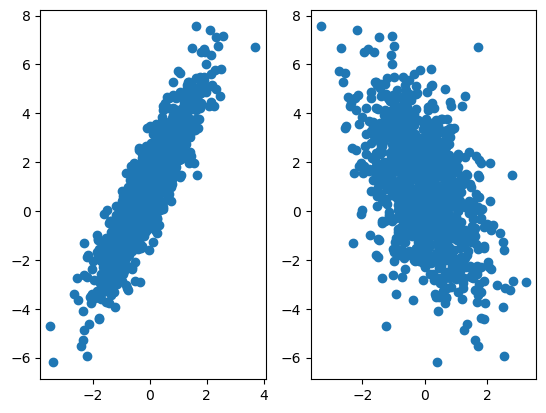

In [9]:
plt.subplot(121)    # 参数解释：1行2列，绘制第1个子图
plt.scatter(features[:, 0], labels)     # 第一个特征和标签的关系
plt.subplot(122)                
plt.scatter(features[:, 1], labels)     # 第二个特征和标签的关系

不难看出，两个特征和标签都存在一定的线性关系，并且跟特征的系数绝对值有很大关系。当然，若要增加线性模型的建模难度，可以增加扰动项的数值比例，从而削弱线性关系。

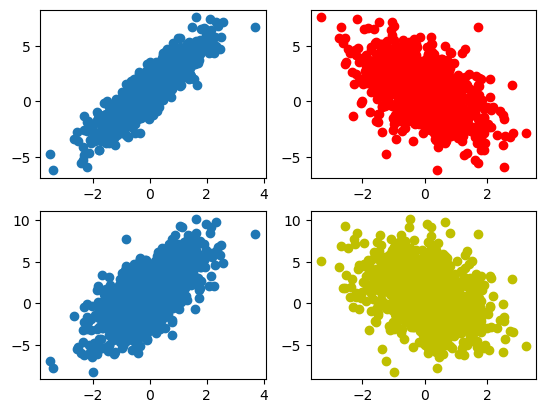

In [11]:
 # 设置随机数种子
torch.manual_seed(420)

# 修改因变量
labels1 = labels_true + torch.randn(size= labels_true.shape)*2

# 可视化展示
# 扰动较小情况

plt.subplot(221)
plt.scatter(features[:, 0], labels)
plt.subplot(222)
plt.plot(features[:, 1], labels, "ro")

# 扰动较大情况
plt.subplot(223)
plt.scatter(features[:, 0], labels1)
plt.subplot(224)
plt.plot(features[:, 1], labels1, 'yo')

当然，我们也能生成非线性关系的数据集，此处我们创建满足 $ y = x^{2} + 1 $ 规律的数据集。

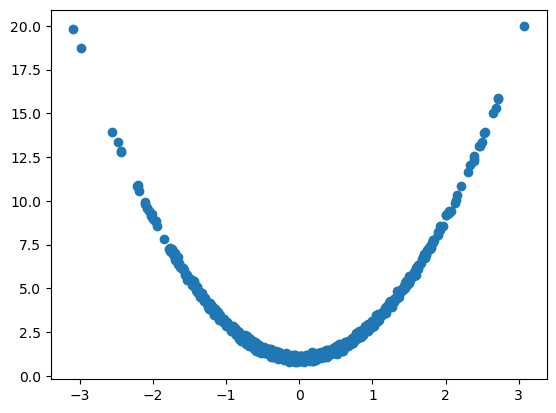

In [13]:
# 设置随机数种子
torch.manual_seed(420)

num_inputs = 1
num_examples = 1000

# 线性方程系数
w_true = torch.tensor(2., dtype= torch.float32)
b_true = torch.tensor(1., dtype= torch.float32)

# 特征和标签取值
features = torch.randn(num_examples, num_inputs)
labels_true = torch.pow(features, 2)*w_true + b_true
labels = labels_true + torch.randn(size= labels_true.shape)*0.1

# 可视化展示
plt.scatter(features, labels)

2. 创建生成回归类数据的函数

为了方便后续使用，我们将上述过程封装在一个函数内

* 定义创建函数

In [ ]:
def tensorGenReg(num_examples = 1000, w = [2, -1, -1], bias = True, delta = 0.01, deg = 1):
    """ 回归类数据集创建函数

    num_examples: 创建数据集的数据量
    w: 包括截距的特征系数张量
    bias: 是否需要截距
    delta: 扰动项取值
    deg: 方程次数
    return: 生成的特征张量和标签张量
    
    """

    if bias == True:
        num_inputs = len(w) - 1                                 
        features_true = torch.randn(num_examples, num_inputs)   # 特征张量
        w_true = torch.tensor(w[:-1]).reshape(-1, 1).float()    # 自变量系数
        b_true = torch.tensor(w[-1]).float()                    # 截距
        if num_inputs == 1:                                     # 若输入特征只有一个，则不能使用矩阵的乘法
            labels_true = torch.pow(features_true, deg)*w_true + b_true
        else:
            labels_true = torch.mm(torch.pow(features_true, deg), w_true) + b_true
        features = torch.cat((features_true, torch.ones(len(features_true), 1)), 1)     # 在特征张量2的最后一列添加一列全是1的列
        labels = labels_true + torch.randn(size = labels_true.shape)*delta
    
    else:
        num_inputs = len(w)
        features = torch.randn(num_examples, num_inputs)
        w_true = torch.tensor(w).reshape(-1, 1).float()
        if num_inputs == 1:                                 # 若输入特征只有一个，则不能使用矩阵的乘法
            labels_true = torch.pow(features_true, deg)*w_true 
        else:
            labels_true = torch.mm(torch.pow(features_true, deg), w_true)
        labels = labels_true + torch.randn(size = labels_true.shape)*delta
    return features,labels

    注：上述函数无法创建带有交叉项（x1x2）的方程

In [20]:
# 经过优化后的代码

def tensorGenReg(num_examples = 1000, w = [2, -1, -1], bias = True, delta = 0.01, deg = 1):
    """ 回归类数据集创建函数

    num_examples: 创建数据集的数据量
    w: 包括截距的特征系数张量
    bias: 是否需要截距
    delta: 扰动项取值
    deg: 方程次数
    return: 生成的特征张量和标签张量
    
    """
    num_inputs = len(w) - 1 if bias else len(w)
    features_true = torch.randn(num_examples, num_inputs)   # 特征张量

    if bias:
        w_true = torch.FloatTensor(w[:-1]).reshape(-1, 1)    # 自变量系数
        b_true = torch.tensor(w[-1]).float()                    # 截距
        features = torch.cat((features_true, torch.ones(len(features_true), 1)), 1)     # 在特征张量2的最后一列添加一列全是1的列
    else:
        w_true = torch.FloatTensor(w).reshape(-1, 1)
        features = features_true

    labels_true = torch.pow(features_true, deg) * w_true if num_inputs == 1 else torch.mm(torch.pow(features_true, deg), w_true)
    labels_true += b_true if bias else 0
    labels = labels_true + torch.randn(size = labels_true.shape)*delta

    return features, labels

* 测试函数性能

首次查看扰动项较小的时候的数据情况

In [27]:
# 设置随机数种子
torch.manual_seed(420)

# 扰动项取值为0.01
f, l = tensorGenReg(delta= 0.01)
f

tensor([[-0.0070,  0.5044,  1.0000],
        [ 0.6704, -0.3829,  1.0000],
        [ 0.0302,  0.3826,  1.0000],
        ...,
        [-0.9164, -0.6087,  1.0000],
        [ 0.7815,  1.2865,  1.0000],
        [ 1.4819,  1.1390,  1.0000]])

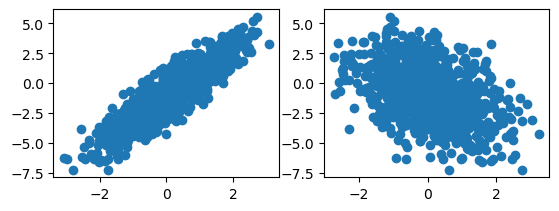

In [28]:
# 绘制图像查看结果
plt.subplot(221)
plt.scatter(f[:, 0], l)
plt.subplot(222)
plt.scatter(f[:, 1], l)

当特征和标签满足二阶关系时候数据表现

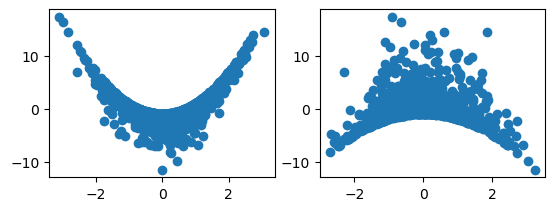

In [30]:
# 设置随机数种子
torch.manual_seed(420)

# 二阶方程
f, l = tensorGenReg(deg= 2)
plt.subplot(223)
plt.scatter(f[: ,0], l)
plt.subplot(224)
plt.scatter(f[:, 1], l)

当只有一个特征时数据表现为：

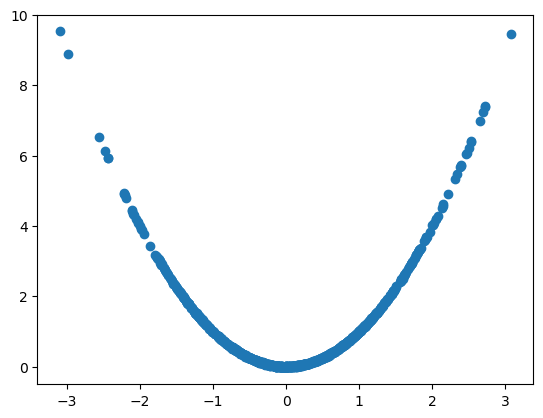

In [32]:
# 设置随机数种子
torch.manual_seed(420)

# 二阶方程
f, l = tensorGenReg(w = [1], deg= 2, bias= False)
plt.scatter(f, l)

## 12.1.2 分类数据集创建方法

1. 手动创建分类数据

* 数据生成

在尝试创建分类数据之前，首先要回顾torch.normal创建某种服从正态分布的随机数的创建方法。

In [33]:
torch.randn(4, 2)

tensor([[ 0.9224,  0.7730],
        [-1.3839,  2.2187],
        [ 0.6917,  0.2761],
        [ 0.0906,  0.0922]])

In [34]:
torch.normal(4, 2, size=(4, 2))

tensor([[3.6904, 5.1456],
        [3.6083, 4.3193],
        [4.7536, 2.0248],
        [5.8271, 2.9010]])

接下来尝试创建一个拥有两个特征的三分类的数据集，每个类别包含500条数据，并且第一个类别的两个特征都服从均值为4,标准差为2的正态分布，第二个类别的两个特征都服从均值为-2,标准差为2的正态分布，第三个类别的两个特征都服从均值为-6,标准差为2的正态分布，创建过程如下：

In [40]:
# 设置随机种子
torch.manual_seed(420)

# 设置特征个数及样本数
num_examples = 500
num_inputs = 2

# 创建数据
data_0 = torch.normal(4, 2, size=(num_examples, num_inputs), dtype= torch.float32)
data_1 = torch.normal(-2, 2, size=(num_examples, num_inputs), dtype= torch.float32)
data_2 = torch.normal(-6, 2, size=(num_examples, num_inputs), dtype= torch.float32)

# 创建标签
labels_0 = torch.zeros(num_examples)
labels_1 = torch.ones(num_examples)
labels_2 = torch.full(size=(num_examples, ), fill_value= 2)

# 合成最终数据
features = torch.cat((data_0, data_1, data_2)).float()
labels = torch.cat((labels_0, labels_1, labels_2)).long().reshape(-1, 1)

> 此处需要注意：
> * normal函数的均值参数位，标准差参数位都允许输入高纬数组，从而最终输出结果也是形状相同的高纬数组
> * 一般来说，约定俗成的方式，是针对多分类问题，类别标记从0开始递增
> * 对PyTorch来说，分类问题标签要求是默认整型

* 数据探索

In [41]:
features[:10]

tensor([[3.9859, 5.0089],
        [5.3407, 3.2343],
        [4.0605, 4.7653],
        [2.9738, 5.4208],
        [7.6183, 4.8705],
        [9.2907, 4.5307],
        [5.8470, 3.1249],
        [8.0364, 6.6997],
        [3.4954, 3.9290],
        [3.8709, 2.8165]])

In [42]:
labels[:10]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

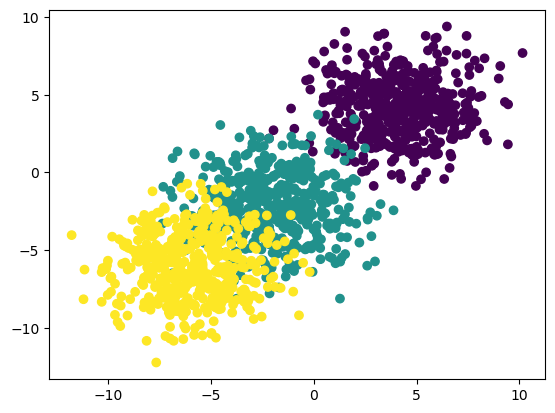

In [43]:
# 可视化展示
plt.scatter(features[:, 0], features[:, 1], c = labels)

能沟看出，类别彼此交叉情况较少，分类器在此数据集上会有不错的表现。当然，若要增加分类器的分类难度，可以将各类的均值压缩，并增加方差，从而增加从二维图像上来看彼此交错的情况。

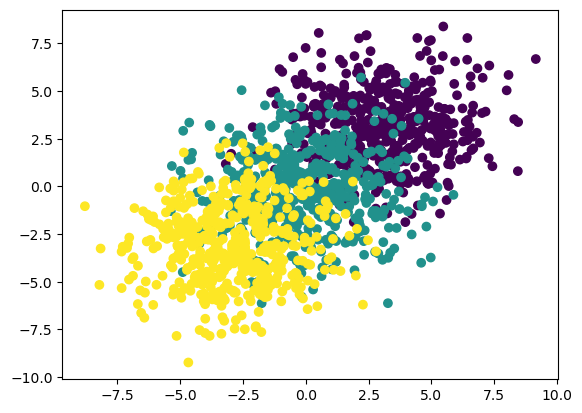

In [44]:
# 设置随机种子
torch.manual_seed(420)

# 设置特征个数及样本数
num_examples = 500
num_inputs = 2

# 创建数据
data_0 = torch.normal(3, 2, size=(num_examples, num_inputs), dtype= torch.float32)
data_1 = torch.normal(0, 2, size=(num_examples, num_inputs), dtype= torch.float32)
data_2 = torch.normal(-3, 2, size=(num_examples, num_inputs), dtype= torch.float32)

# 创建标签
labels_0 = torch.zeros(num_examples)
labels_1 = torch.ones(num_examples)
labels_2 = torch.full(size=(num_examples, ), fill_value= 2)

# 合成最终数据
features = torch.cat((data_0, data_1, data_2)).float()
labels = torch.cat((labels_0, labels_1, labels_2)).long().reshape(-1, 1)

# 可视化展示
plt.scatter(features[:, 0], features[:, 1], c = labels)

2. 创建生成分类数据的函数

同样，我们将上述创建分类函数的过程封装为一个函数。这里需要注意的是，我们希望找到一个变量可以控制数据整体离散程度，也就是后续建模的难易程度。这里我们规定，如果每个分类数据集中心点较近，且每个类别的点内部方差较大，则数据集整体离散程度较高，反之离散程度较低。在实际函数创建过程中，我们也希望能够找到对应的参数能沟方便进行自主调节。

* 定义创建函数

In [45]:
def tensorGenCla(num_examples = 500, num_inputs = 2, num_class = 3, deg_dispersion = [4, 2], bias = False):
    """ 分类数据集创建函数
    num_examples: 每个类别的数据数量
    num_inputs: 数据集特征数量
    num_class: 数据集标签类别总数
    deg_dispersion: 数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考，第二个参数表示随机数组标准差。
    bias: 建立模型逻辑回归模型时是否带入截距
    return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组
    """

    cluster_1 = torch.empty(num_examples, 1)        # 每一类标签张量的形状
    mean_ = deg_dispersion[0]                       # 每一类特征张量的均值的参考值
    std_ = deg_dispersion[1]                        # 每一类特征张量的方差
    lf = []                                         # 用于存储每一类特征张量的列表容器
    ll = []                                         # 用于存储每一类标签张量的列表容器
    k = mean_*(num_class - 1) / 2                 # 每一类特征张量的惩罚因子

    for i in range(num_class):
        data_temp = torch.normal(i*mean_-k, std_, size=(num_examples, num_inputs))      # 生成每一类张量
        lf.append(data_temp)                                                            # 将每一类张量添加到Lf中
        labels_temp = torch.full_like(cluster_1, i)                                     # 生成标签
        ll.append(labels_temp)
    
    features = torch.cat(lf).float()
    labels = torch.cat(ll).long()

    if bias == True:
        features = torch.cat((features, torch.ones(len(features), 1)), 1)
    return features, labels

函数整体结构并不复杂，且所使用的方法都是此前介绍过的tensor常用方法，唯一需要注意的是函数对于分布离散程度的控制。函数内部变量K是一个随着均值增加和分类类别数量增加而增加的数值，且分类数量增加对K值影响是通过和1取平均后进行惩罚的结果。而 i*mean_则是一个随着i增加稳步增加的量，二者相减最终能获得一个整体均匀分布在0附近的特征张量。

* 测试函数的性能

在使用函数的过程中，离散度的第一个数值可以理解为簇的大概分布区间，第二个数值可以理解为每个簇的离散程度

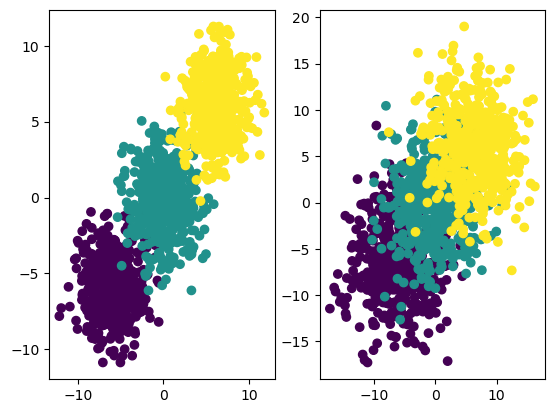

In [47]:
# 设置随机数种子
torch.manual_seed(420)

# 创建数据
f, l = tensorGenCla(deg_dispersion= [6, 2])     # 离散程度较小
f1, l1 = tensorGenCla(deg_dispersion= [6, 4])   # 离散程度较大

# 绘制图像查看
plt.subplot(121)
plt.scatter(f[:, 0], f[:, 1], c= l)
plt.subplot(122)
plt.scatter(f1[:, 0], f1[:, 1], c= l1)

## 12.1.3 创建；小批量切分函数

在深度学习建模过程中，梯度下降是最常用的求解目标函数的优化算法，而针对不同类型，拥有不同函数特性的目标函数，所使用的梯度下降算法也各不相同。目前位置，我们判断小批量梯度下降是较为普适的优化算法，它既拥有随机梯度下降能沟跨越局部最小值点的特性，同时又和小批量梯度下降一样，拥有相对较快的收敛速度（虽然速度略慢于BGD）。而在小批量梯度下降过程中，我们需要对函数进行分批量的切分，因此，在手动实现各类深度学习基础算法之前，我们需要定义数据集小批量切分的函数。

    另外，后续讲解的交叉验证计算过程也需要对数据进行切分

shuffle过程：将原序乱序排列

In [48]:
l = list(range(5))
l

[0, 1, 2, 3, 4]

In [49]:
random.shuffle(l)
l

[2, 4, 1, 0, 3]

In [50]:
# 设置随机数种子
torch.manual_seed(420)

# 生成三分类数据集
features, labels = tensorGenCla()

批量切分函数的目标就是根据设置的“批数”，将原数据集随机均匀切分，可通过如下函数实现：

In [51]:
def data_iter(batch_size, features, labels):
    """ 数据切分函数
    batch_size : 每个子数据集包含多少数据
    features: 输入的特征张量
    labels: 输入的标签张量
    return l: 包含batch_size个列表,每个列表由切分后的特征和标签所构成
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    l = []
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        l.append([torch.index_select(features, 0, j), torch.index_select(labels, 0, j)])
    return l

In [52]:
for i in range(0, 5, 2):
    print(i)

0
2
4


In [53]:
# 设置随机数种子
torch.manual_seed(420)

# 生成三分类数据集
features, labels = tensorGenCla()
features[:5]

tensor([[-4.0141, -2.9911],
        [-2.6593, -4.7657],
        [-3.9395, -3.2347],
        [-5.0262, -2.5792],
        [-0.3817, -3.1295]])

In [55]:
l = data_iter(10, features, labels)

In [56]:
l[0]

[tensor([[ 3.7905,  0.4762],
         [-4.2744, -2.5124],
         [-0.3960,  0.3799],
         [ 1.4358, -6.1974],
         [ 1.6356, -0.5503],
         [ 2.4766,  4.6981],
         [-2.3476, -1.5569],
         [-3.7580, -0.8133],
         [-2.8175, -3.9851],
         [-4.8585, -4.4315]]),
 tensor([[1],
         [0],
         [1],
         [0],
         [1],
         [2],
         [0],
         [0],
         [0],
         [0]])]

    此处又使用了空列用于存储数据。在经典机器学习领域，我们经常使用空的列表来存储经过处理之后的数据，这么做能让我们非常清楚的看到数据的真实情况，但在深度学习领域，这么做却不是那么常规的操作。在深度学习领域，数据量往往非常大，甚至数据本身是分布式存储的，要调取数据进行完整的查看，一方面会耗费大量的存储空间，另一方面也会消耗一定的算力，因此PyTorch的Dataset和DataLoader都是将数据进行迭代存储或者映射存储，关于数据生成器的相关内容我们将在后续进行讨论，此处由于我们是进行手动实验，将处理完的数据完整的存在列表容器中则是为了方便调用查看，是一种更适合初学者的方法。
    